# Preparing the enviroment

We will be using environment variables for Portia's information (keys, URLs, etc.) and some Spark/pyspark directives.

Please refer to [this link](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-env) for more information about Jupyter Magics for environment variables.

```bash
%env PYSPARK_PYTHON        = python3.6
%env PYSPARK_DRIVER_PYTHON = python3.6
```

Alternatively, you may handle the environment variables programmatically via python itself

```python
import os 
os.environ["PYSPARK_PYTHON"]        = "python3.6"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python3.6"
```

Here we will be using [python-dotenv](https://github.com/theskumar/python-dotenv). Feel free to also [source](https://bash.cyberciti.biz/guide/Source_command) the file in bash (the "source" command within the file is ignored by python-dotenv)


In [1]:
# loading .env  
import dotenv  
import pathlib 
dotenv.load_dotenv(dotenv_path=pathlib.Path('../env'))

True

## Setting up PySpark

In [2]:
import os 
from pyspark import SparkConf, SparkContext

In [3]:
conf  = SparkConf().setMaster(os.getenv("SPARK_MASTER_URL")).setAppName("portia-integration")
spark = SparkContext(conf = conf)

## Setting up Portia

In [4]:
from portiapy.portia  import PortiaApi
from portiapy.profile import ProfileStrategies
from portiapy.summary import SummaryStrategies
import json

portia = PortiaApi({
    'baseurl': os.getenv("PORTIA_BASEURL") ,
    'authorization': os.getenv("PORTIA_KEY"), 
    'debug': bool(os.getenv("PORTIA_DEBUG") == 'True')
})

### Params

In [5]:
summary_params = {
#    'from': grafana_from_timestamp,
#    'to': grafana_to_timestamp,
    'order': '1',
    'precision': 'ms',
    'min': True,
    'max': True,
    'sum': False,
    'avg': False,
    'median': False,
    'mode'  : False,
    'stddev': False,
    'spread': False
}

select_params = {
#     'from': None,
#     'to': None,
    'order': None,
    'precision': 'ms',
#     'limit': 1
}

In [66]:
edgeids   = os.getenv("EDGEIDS").split(',')


In [7]:
ports_df = portia.device(edgeids[0]).ports(last=True)
ports_df.humanize(datetime=True)

,header_datetime,port,dimension_thing
0,5 minutes ago,1,SondaTU_v1
1,just now,2,SondaTU_v1
2,seconds ago,3,SondaAirQ_v1


In [8]:
summary_df = portia.device(edgeids[0]).port(1).sensor(1).summary(strategy=SummaryStrategies.PER_DAY, interval=1, params=summary_params)
summary_df.head(5)

,header_timestamp,min,max,number_of_packages,Unnamed: 4
0,1522800000000,23.8,31.8,401,NaN
1,1522886400000,19.7,33.9,1427,NaN
2,1522972800000,21.5,33.4,1425,NaN
3,1523059200000,21.0,34.5,1426,NaN
4,1523145600000,19.9,35.6,1420,NaN


In [9]:
df = portia.device(edgeids[0]).port(1).sensor(1).select(params=select_params, last=True)
df.head(3)

,header_timestamp,dimension_value,dimension_code,dimension_unity_code,dimension_thing_code,Unnamed: 5
0,1548696634026,34,1,1,1,NaN


In [10]:
df = portia.device(edgeids[0]).port(1).sensor(1).select(params=select_params)

df.head(5)

,header_timestamp,dimension_value,dimension_code,dimension_unity_code,dimension_thing_code,Unnamed: 5
0,1548696634026,34.0,1,1,1,NaN
1,1548696453163,34.0,1,1,1,NaN
2,1548696392513,34.0,1,1,1,NaN
3,1548696331769,34.0,1,1,1,NaN
4,1548696271755,34.0,1,1,1,NaN


In [11]:
df = portia.device(edgeids[0]).port(1).sensor(1).select(params=select_params)#.humanize(datetime=True)
df.head(5)

,header_timestamp,dimension_value,dimension_code,dimension_unity_code,dimension_thing_code,Unnamed: 5
0,1548696634026,34.0,1,1,1,NaN
1,1548696453163,34.0,1,1,1,NaN
2,1548696392513,34.0,1,1,1,NaN
3,1548696331769,34.0,1,1,1,NaN
4,1548696271755,34.0,1,1,1,NaN


AxesSubplot(0.125,0.125;0.775x0.755)


(22729, 6)

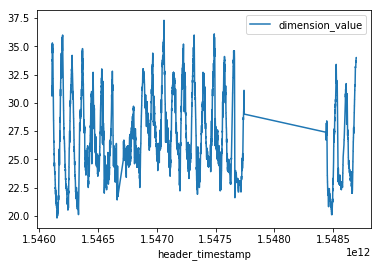

In [20]:
df = portia.device(edgeids[0]).port(1).sensor(1).select(params=select_params)

print(df.plot(x='header_timestamp', y='dimension_value'))
df.shape

## Integrating Portia with Spark RDDs

In [21]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)
spark_df = sqlContext.createDataFrame(df)
spark_df.head(5)

[Row(header_timestamp=1548696634026, dimension_value=34.0, dimension_code=1, dimension_unity_code=1, dimension_thing_code=1, Unnamed: 5=nan),
 Row(header_timestamp=1548696453163, dimension_value=34.0, dimension_code=1, dimension_unity_code=1, dimension_thing_code=1, Unnamed: 5=nan),
 Row(header_timestamp=1548696392513, dimension_value=34.0, dimension_code=1, dimension_unity_code=1, dimension_thing_code=1, Unnamed: 5=nan),
 Row(header_timestamp=1548696331769, dimension_value=34.0, dimension_code=1, dimension_unity_code=1, dimension_thing_code=1, Unnamed: 5=nan),
 Row(header_timestamp=1548696271755, dimension_value=34.0, dimension_code=1, dimension_unity_code=1, dimension_thing_code=1, Unnamed: 5=nan)]

In [22]:
spark_df.printSchema()

root
 |-- header_timestamp: long (nullable = true)
 |-- dimension_value: double (nullable = true)
 |-- dimension_code: long (nullable = true)
 |-- dimension_unity_code: long (nullable = true)
 |-- dimension_thing_code: long (nullable = true)
 |-- Unnamed: 5: double (nullable = true)



In [25]:
spark_df = spark_df.drop("Unnamed: 5")
spark_df.printSchema()

root
 |-- header_timestamp: long (nullable = true)
 |-- dimension_value: double (nullable = true)
 |-- dimension_code: long (nullable = true)
 |-- dimension_unity_code: long (nullable = true)
 |-- dimension_thing_code: long (nullable = true)



In [26]:
spark_df.select("dimension_value","header_timestamp").orderBy("header_timestamp", ascending=False).show()

+---------------+----------------+
|dimension_value|header_timestamp|
+---------------+----------------+
|           34.0|   1548696634026|
|           34.0|   1548696453163|
|           34.0|   1548696392513|
|           34.0|   1548696331769|
|           34.0|   1548696271755|
|           33.9|   1548696211735|
|           33.8|   1548695971196|
|           33.8|   1548695910711|
|           33.7|   1548695790651|
|           33.7|   1548695730673|
|           33.6|   1548695550426|
|           33.6|   1548695490278|
|           33.6|   1548695430224|
|           33.6|   1548695370183|
|           33.7|   1548695129337|
|           33.7|   1548695068561|
|           33.7|   1548694947732|
|           33.6|   1548694827067|
|           33.6|   1548694705626|
|           33.5|   1548694584952|
+---------------+----------------+
only showing top 20 rows



In [62]:
from operator import add
spark_df.select("dimension_value").rdd.map(lambda a: (1, a['dimension_value'])).reduceByKey(lambda a,b: a + b).collect()

[(1, 600954.6999999998)]

In [63]:
spark_df.select("dimension_value").rdd

MapPartitionsRDD[255] at javaToPython at <unknown>:0

In [65]:
spark_df.s

DataFrame[header_timestamp: bigint, dimension_value: double, dimension_code: bigint, dimension_unity_code: bigint, dimension_thing_code: bigint]